In [41]:
import pandas as pd
import yfinance as yf
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

In [42]:
stk_data = yf.Ticker("SPY")
print(stk_data.ticker)
stk_data.history(period='10y')

SPY


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2011-08-15,97.946289,99.220022,97.790151,99.121414,258810600,0.0,0
2011-08-16,98.176416,99.178972,97.223165,98.275024,294095200,0.0,0
2011-08-17,98.817378,99.598053,97.560076,98.340752,238201100,0.0,0
2011-08-18,95.735754,98.373622,93.180061,94.100441,512956300,0.0,0
2011-08-19,92.826686,95.226241,92.448674,92.563721,428281300,0.0,0
...,...,...,...,...,...,...,...
2021-08-09,442.459991,442.799988,441.309998,442.130005,41222600,0.0,0
2021-08-10,442.609985,443.440002,441.880005,442.679993,43339300,0.0,0
2021-08-11,443.820007,443.880005,442.619995,443.779999,44034300,0.0,0


<AxesSubplot:xlabel='Date'>

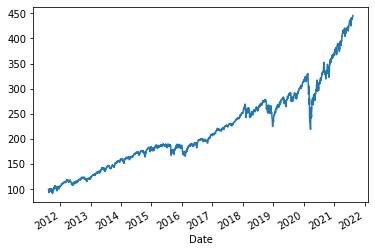

In [43]:
prices = stk_data.history(period='10y').Close
prices.plot()

MinMaxScaler()

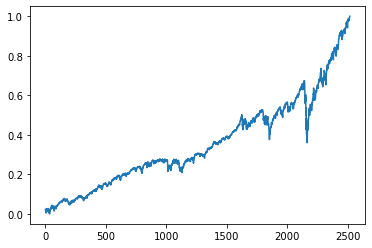

In [44]:
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(prices.values.reshape(-1,1))[:,0]
sns.lineplot(x=np.arange(0,len(scaled_prices)), y=scaled_prices)
scaler

In [45]:
#Use previous 60-days to predict next 10-days
prices_len = len(scaled_prices)

prev_100_lst = []
next_1_lst = []

for i in range(prices_len - 100):
    prev_100_day = scaled_prices[i:i+100]
    prev_100_lst.append(prev_100_day)

    next_1_day = scaled_prices[i+100]
    next_1_lst.append(next_1_day)

X = np.array(prev_100_lst)
y = np.array(next_1_lst)
print(X.shape, y.shape)

X_train = X[:-60]
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X[len(X)-60:]
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

y_train = y[:-60]
y_train = y_train.reshape(-1,1)
y_test = y[len(y)-60:]
y_test = y_test.reshape(-1,1)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(2417, 100) (2417,)
(2357, 100, 1) (60, 100, 1)
(2357, 1) (60, 1)


## Model

In [79]:
from keras.layers import Dense, LSTM
from keras.models import Sequential

def LSTM_model():
    model = Sequential()
    model.add(LSTM(100, input_shape=(X.shape[1],1), return_sequences=True))
    model.add(LSTM(75, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model = LSTM_model()

In [80]:
from keras.callbacks import EarlyStopping
np.random.seed(1)

callback = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True, verbose=1)

model.fit(X_train, y_train, epochs=50, callbacks=[callback])
# model.fit(X_train, y_train)

Epoch 1/50
74/74 [==============================] - 16s 156ms/step - loss: 0.0055
Epoch 2/50
74/74 [==============================] - 11s 146ms/step - loss: 4.5293e-04
Epoch 3/50
74/74 [==============================] - 10s 136ms/step - loss: 3.8138e-04
Epoch 4/50
74/74 [==============================] - 10s 137ms/step - loss: 3.6371e-04
Epoch 5/50
74/74 [==============================] - 10s 139ms/step - loss: 3.4907e-04
Epoch 6/50
74/74 [==============================] - 10s 138ms/step - loss: 3.3584e-04
Epoch 7/50
74/74 [==============================] - 10s 141ms/step - loss: 3.7525e-04
Epoch 8/50
74/74 [==============================] - 10s 139ms/step - loss: 3.4662e-04
Epoch 9/50
74/74 [==============================] - 10s 139ms/step - loss: 2.6699e-04
Epoch 10/50
74/74 [==============================] - 10s 141ms/step - loss: 2.3899e-04
Epoch 11/50
74/74 [==============================] - 10s 139ms/step - loss: 2.8761e-04
Epoch 12/50
74/74 [==============================] - 10s

In [81]:
model.evaluate(X_test, y_test)
y_pred_train = model.predict(X_train)

2/2 [==============================] - 1s 68ms/step - loss: 6.8275e-05


<AxesSubplot:>

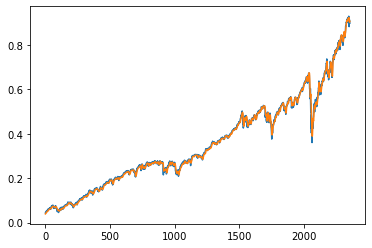

In [82]:
sns.lineplot(x=np.arange(0,len(X_train)), y= y_train[:,0])
sns.lineplot(x=np.arange(0,len(y_train)), y= y_pred_train[:,0])

<AxesSubplot:>

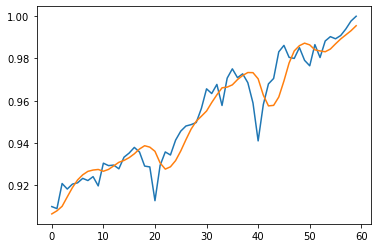

In [83]:
y_pred_test = model.predict(X_test)
sns.lineplot(x=np.arange(0,len(X_test)), y= y_test[:,0])
sns.lineplot(x=np.arange(0,len(y_test)), y= y_pred_test[:,0])

In [84]:
scaler.inverse_transform(y_pred_test)

array([[412.69476],
       [413.2161 ],
       [413.97275],
       [415.55923],
       [417.1181 ],
       [418.40475],
       [419.27017],
       [419.84763],
       [420.06775],
       [420.16568],
       [419.86423],
       [420.17645],
       [420.76688],
       [421.36847],
       [421.6843 ],
       [422.1552 ],
       [422.80026],
       [423.60443],
       [424.15704],
       [423.9179 ],
       [423.21683],
       [421.25897],
       [420.22375],
       [420.6139 ],
       [421.65567],
       [423.27664],
       [425.16644],
       [426.94138],
       [428.2751 ],
       [429.116  ],
       [429.9877 ],
       [431.4141 ],
       [432.70844],
       [433.89117],
       [434.00916],
       [434.38824],
       [435.27475],
       [435.96188],
       [436.45978],
       [436.43738],
       [435.4027 ],
       [432.67133],
       [430.85474],
       [430.93808],
       [432.34174],
       [435.03946],
       [438.06293],
       [440.0911 ],
       [440.97137],
       [441.39835],
